# 1. Load the data file and libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn import neighbors, linear_model
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import classification_report
%matplotlib inline

red_wine = pd.read_csv("winequality-red.csv", sep=';')

# 2. Construct a new binary column indicating whether the wine is good or not

In [2]:
original_outcome = red_wine['quality'].values

good_wine = original_outcome >= 6 # this converts values to either true or false
# convert to 0 and 1
good_wine = good_wine*1

# 3. Normalize the data

An issue with this dataset is the different scales used to measure the input variables;
for example chlorides (ranges between 0.012 and 0.6)and total sulfur dioxide (ranges between 6 and 289).
As a result, we need to scale/standardize the input data.

We plot the histograms of all the columns in our data set to highlight this issue.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002379B4A75C0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002379BB78358>]], dtype=object)

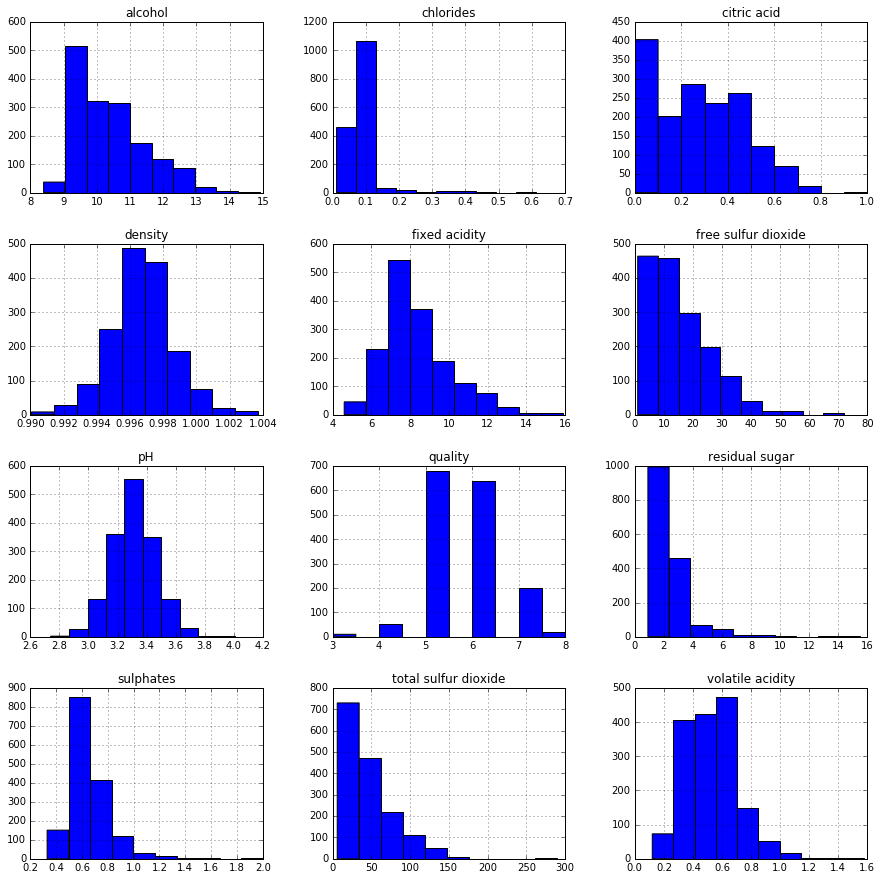

In [3]:
pd.DataFrame.hist(red_wine, figsize=[15,15])

In [4]:
# remove the outcome variable and keep only the input variables
input_cols = list(red_wine.ix[:, red_wine.columns != 'quality'].columns)


In [5]:
# compute the z-score for all input variables
red_transform = pd.DataFrame()
for col in input_cols:
    red_transform[col + '_zscore'] = (red_wine[col] - red_wine[col].mean()) / red_wine[col].std()

predictors_z = red_transform.values

The data is now normalized centered around zero (mean = 0) with standard deviation = 1.

# 4. Split the data into random training and test subsets

In [6]:
Z_train, Z_test, y_train, y_test = train_test_split(predictors_z, good_wine,
                                                    test_size=0.5,
                                                    random_state=42)

In [8]:
Z_test

array([[-0.35588914,  0.17971373, -0.98036188, ..., -0.46061807,
         0.01092083, -0.77227001],
       [-0.29845406, -0.15537004, -0.51835226, ...,  0.51096969,
        -1.05098235, -0.8661079 ],
       [ 1.36716315,  0.79403397, -0.26168025, ..., -0.201528  ,
         1.8987487 , -0.49075633],
       ..., 
       [-0.81536975, -0.09952274, -0.21034584, ...,  0.57574221,
         1.07282401,  0.72913627],
       [-0.64306452,  1.12911773, -1.2883683 , ...,  0.83483228,
        -0.81500386, -1.05378369],
       [ 1.88407884, -0.65799569,  1.38102063, ..., -1.88561346,
         0.60086704, -0.49075633]])

# 5. Train the k-Nearest Neighbours classifiers

In [7]:
acc_dict = dict()
for i in np.arange(1, 500, 5):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(Z_train, y_train)

# 6. Evaluate each classifier using 5-fold cross validation

We will get 5 folds, each with 320 points used for validation and 1280 used for training the data.
For each k, we find the average accuracy of all the folds and then we choose the k with the highest accuracy.

In [9]:
# 5-fold cross validation with k = 5
kfold = KFold(1599, n_folds=5)
#for iteration, data in enumerate(kfold, start=1):
#    print(iteration, data[0], data[1])

# find accuracy of all ks
scores_dict = dict()
for i in np.arange(1, 500, 5):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    # use classification accuracy as the evaluation metric
    scores = cross_val_score(knn, Z_train, y_train, cv=5, scoring='accuracy')
    #print(scores)
    #print(scores.mean())
    scores_dict[i] = round(float(scores.mean()),3)

## Optimal k

In [11]:
max(scores_dict, key=scores_dict.get)

86

## Cross-Validated accuracy for optimal k

In [12]:
scores_dict[max(scores_dict, key=scores_dict.get)]

0.752

# 7. Predict the generalisation error using the test data set

In [13]:
knn = neighbors.KNeighborsClassifier(n_neighbors=max(scores_dict, key=scores_dict.get))
model = knn.fit(Z_train, y_train)
y_true, y_pred = y_test, model.predict(Z_test)
#print(classification_report(y_true, y_pred))
error = 1 - model.score(Z_test, y_test)
print(error) #Generalisation Errors

0.2725


## Confusion Matrix

In [14]:
conf1 = sum((y_pred == 1) & (y_true == 1))
conf2 = sum((y_pred == 0) & (y_true == 1))
conf3 = sum((y_pred == 1) & (y_true == 0))
conf4 = sum((y_pred == 0) & (y_true == 0))
    
conf = pd.DataFrame([[conf1,conf2],[conf3,conf4]])
conf.columns = ['Good','Bad']
conf.rename({0:'Good',1:'Bad'}, inplace = True)

print(conf)

      Good  Bad
Good   328   86
Bad    132  254


# Suitability of classifier

As shown above, with this particular random training/test data split, we achieve an error rate of 27.25%. This is not a particularly good estimate but is the best $k$ that we found. Similar to the previous classifer on the white wines, we realise that the variance in optimal $k$ is very high, and it varies heavily with the randomised training/test split.

If we look at the confusion matrix, the classifer does a relatively good job predicting good wines, however, when it comes to bad wines, the classifer only manages to correctly classify roughly 65% of the wines. Similarly, we are more inclined to filter out bad wines and would prefer to err on the side of caution. Instead of using a binary classifier, we could give probabilities equal to the proportion of nearest neighbours in each class. For example, for $k=100$, if a point has 70 "good" neighbours and 30 "bad" neighbours, then we would assign the point to the class "good" with probability 0.7. In the binary case, we would assign the point to the class with probability greater or equal to 0.5, however, if if we assign probabilities instead, we can be more conservative, and only assign a wine to the "good" class if it has a probability of being "good" at say 0.6 or higher.

When finding the optimum $k$, we could also assign costs to misclassification, where we want to minimise the total cost of misclassification. In this classifier, we assigned equal weights to the case "assigned good wine to bad class" and "assigned bad wine to good class". Similar to the probability alternative above, we could assign a higher penalty to the case "assigned bad wine to good class" and instead of minimising error, we find the $k$ that minimises the cost of misclassification.